# IoTID20 DoS Detection Results
## ML Models Performance Comparison (Base Paper Reproduction)

This notebook visualizes the results from training Decision Tree, Random Forest, KNN, and SVM classifiers on:
- All features
- CFS-selected features (top 13)
- GA-selected features (top 13)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from pathlib import Path

# Set styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Results

In [2]:
# Load metrics
metrics_path = '../outputs/metrics.csv'
try:
    metrics_df = pd.read_csv(metrics_path)
    print(f"Loaded metrics with shape: {metrics_df.shape}")
    print("\nMetrics DataFrame:")
    print(metrics_df)
except FileNotFoundError:
    print(f"Metrics file not found at {metrics_path}")
    print("Please run main.py first to generate results.")
    metrics_df = None

Loaded metrics with shape: (12, 9)

Metrics DataFrame:
   FeatureSet    Classifier  n_features  Accuracy  Precision    Recall  \
0         All  DecisionTree          77  0.999421   0.999541  0.999490   
1         All  RandomForest          77  0.999452   0.999643  0.999439   
2         All           KNN          77  0.997106   0.998977  0.996173   
3         All           SVM          77  0.882799   0.837107  0.997908   
4         CFS  DecisionTree          13  0.998538   0.998979  0.998571   
5         CFS  RandomForest          13  0.998812   0.999387  0.998622   
6         CFS           KNN          13  0.996009   0.999180  0.994133   
7         CFS           SVM          13  0.991256   0.997271  0.988061   
8          GA  DecisionTree          13  0.999604   0.999847  0.999490   
9          GA  RandomForest          13  0.999604   0.999847  0.999490   
10         GA           KNN          13  0.999086   0.999235  0.999235   
11         GA           SVM          13  0.970814   1.000

## 2. Performance Metrics Comparison

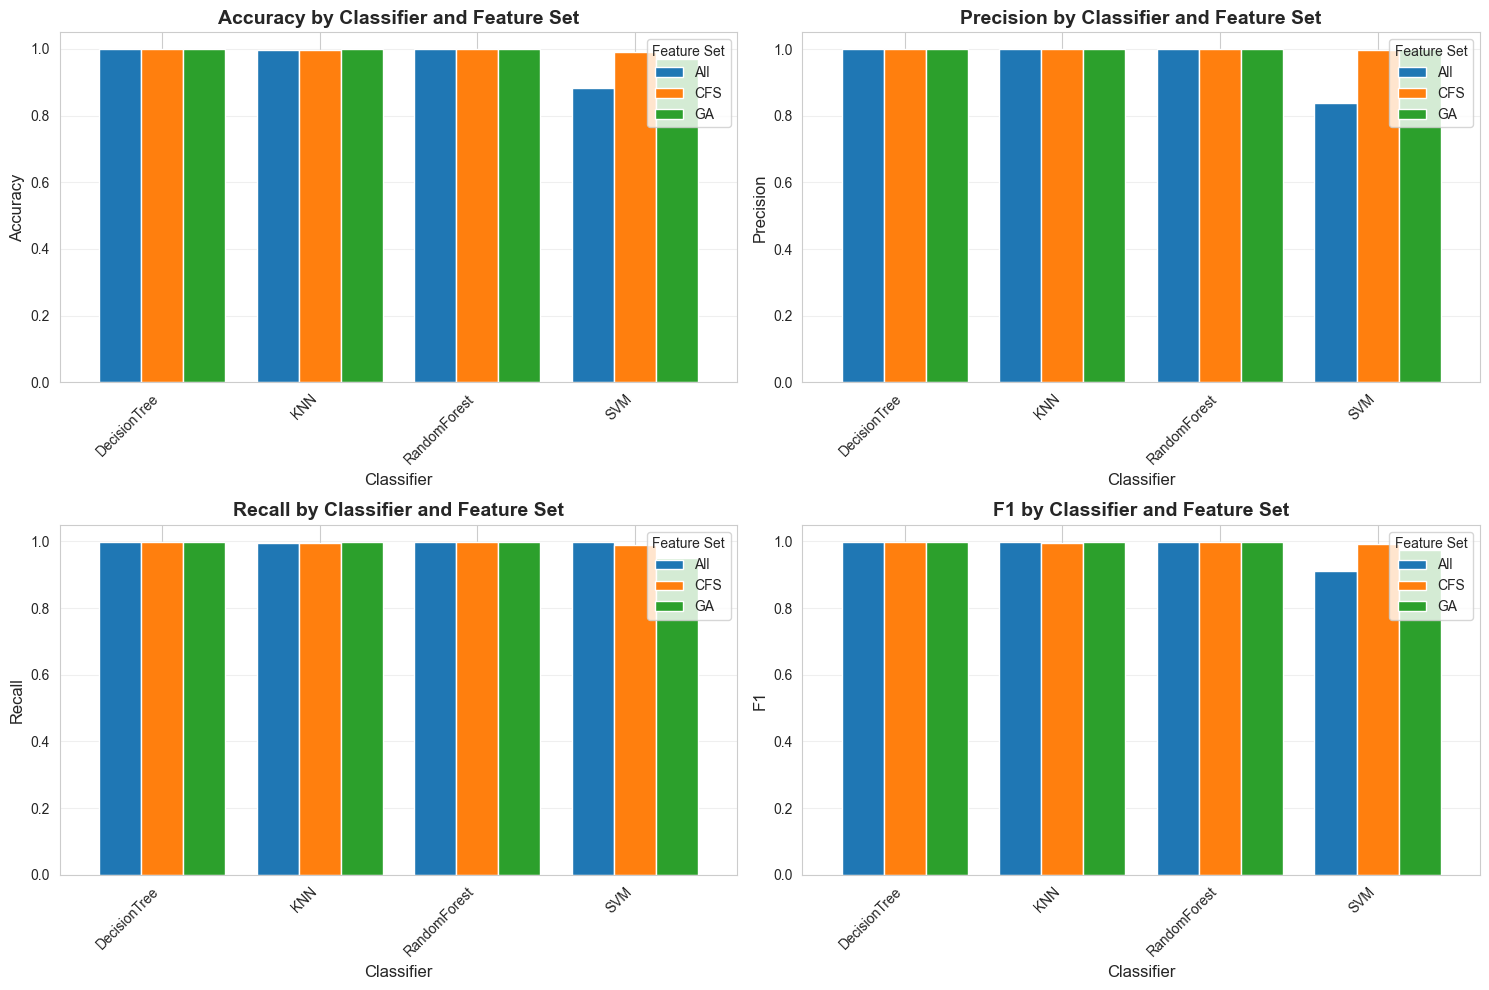


BEST PERFORMERS:

Accuracy: 0.9996
  Classifier: DecisionTree
  Feature Set: GA (13 features)

Precision: 1.0000
  Classifier: SVM
  Feature Set: GA (13 features)

Recall: 0.9995
  Classifier: DecisionTree
  Feature Set: All (77 features)

F1: 0.9997
  Classifier: DecisionTree
  Feature Set: GA (13 features)


In [3]:
if metrics_df is not None:
    # Plot all performance metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        
        # Pivot for grouped bar chart
        pivot_data = metrics_df.pivot(index='Classifier', columns='FeatureSet', values=metric)
        pivot_data.plot(kind='bar', ax=ax, width=0.8)
        
        ax.set_title(f'{metric} by Classifier and Feature Set', fontsize=14, fontweight='bold')
        ax.set_xlabel('Classifier', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(title='Feature Set', fontsize=10)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)
        
    plt.tight_layout()
    plt.show()
    
    # Print best performers
    print("\n" + "="*60)
    print("BEST PERFORMERS:")
    print("="*60)
    for metric in metrics_to_plot:
        best_idx = metrics_df[metric].idxmax()
        best_row = metrics_df.loc[best_idx]
        print(f"\n{metric}: {best_row[metric]:.4f}")
        print(f"  Classifier: {best_row['Classifier']}")
        print(f"  Feature Set: {best_row['FeatureSet']} ({int(best_row['n_features'])} features)")

## 3. Training and Testing Time Analysis

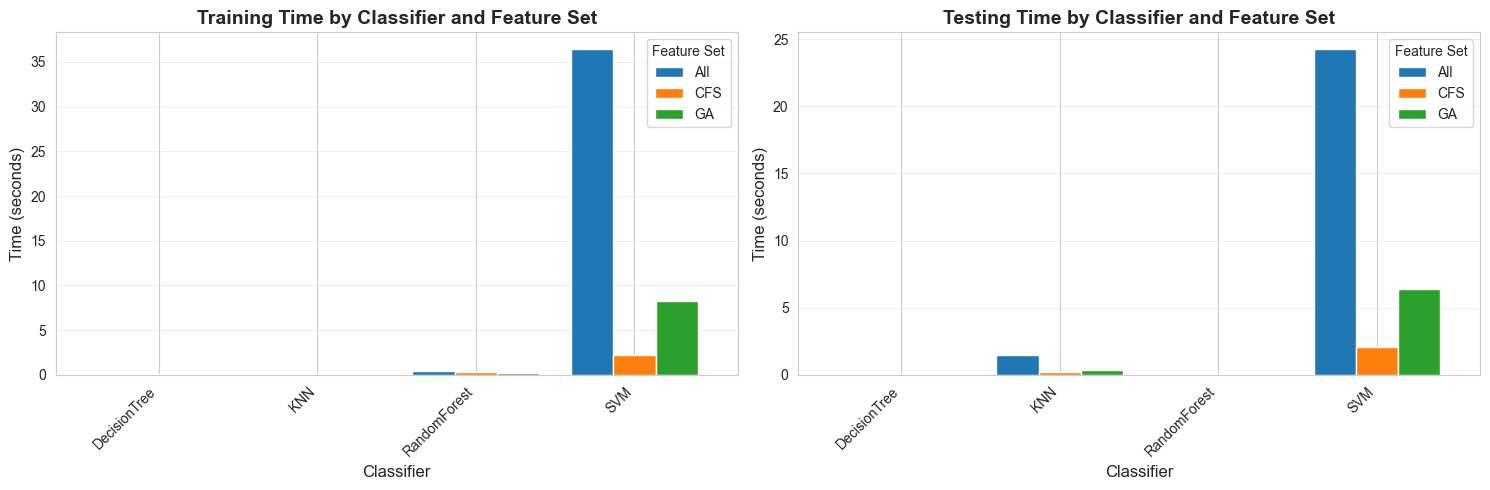

In [4]:
if metrics_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Training time
    pivot_train = metrics_df.pivot(index='Classifier', columns='FeatureSet', values='TrainTime')
    pivot_train.plot(kind='bar', ax=axes[0], width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0].set_title('Training Time by Classifier and Feature Set', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Classifier', fontsize=12)
    axes[0].set_ylabel('Time (seconds)', fontsize=12)
    axes[0].legend(title='Feature Set')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Testing time
    pivot_test = metrics_df.pivot(index='Classifier', columns='FeatureSet', values='TestTime')
    pivot_test.plot(kind='bar', ax=axes[1], width=0.8, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1].set_title('Testing Time by Classifier and Feature Set', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Classifier', fontsize=12)
    axes[1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1].legend(title='Feature Set')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Confusion Matrices

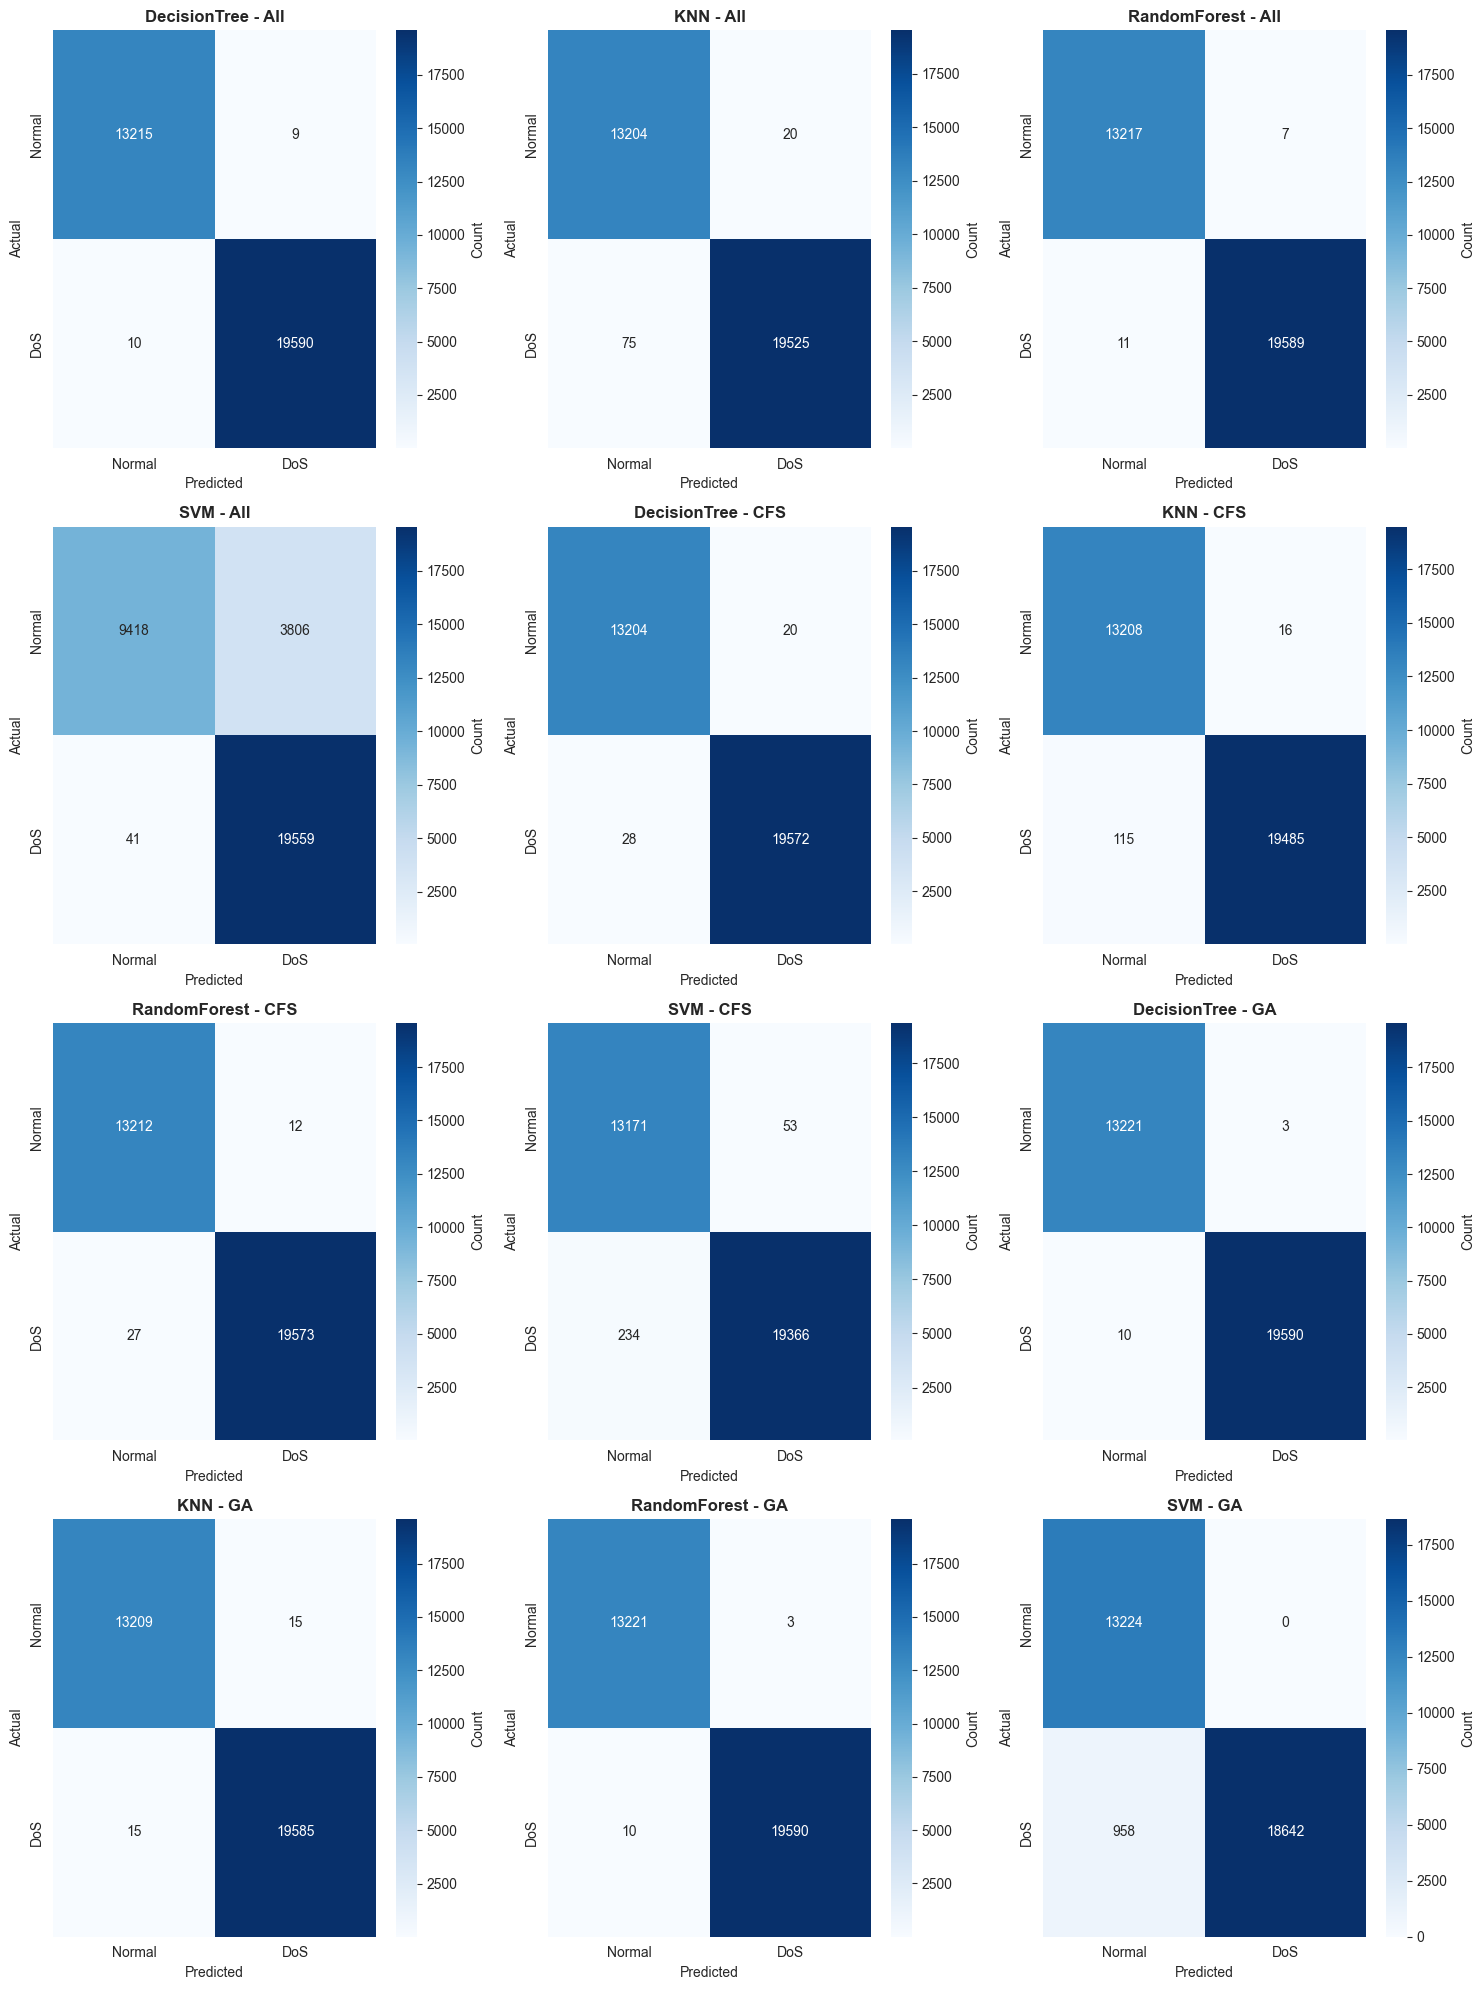

In [5]:
# Load and plot confusion matrices
confmat_files = sorted(glob.glob('../outputs/confmat_*.csv'))

if confmat_files:
    # Determine grid size
    n_files = len(confmat_files)
    n_cols = 3
    n_rows = (n_files + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, cm_file in enumerate(confmat_files):
        cm = pd.read_csv(cm_file).values
        
        # Extract feature set and classifier from filename
        filename = Path(cm_file).stem
        parts = filename.replace('confmat_', '').split('_')
        feat_set = parts[0]
        classifier = '_'.join(parts[1:])
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                    cbar_kws={'label': 'Count'})
        axes[idx].set_title(f'{classifier} - {feat_set}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xticklabels(['Normal', 'DoS'])
        axes[idx].set_yticklabels(['Normal', 'DoS'])
    
    # Hide unused subplots
    for idx in range(len(confmat_files), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No confusion matrix files found in ../outputs/")

## 5. Summary Table

In [6]:
if metrics_df is not None:
    # Create a comprehensive summary table
    summary = metrics_df.copy()
    summary = summary.round({
        'Accuracy': 4,
        'Precision': 4,
        'Recall': 4,
        'F1': 4,
        'TrainTime': 3,
        'TestTime': 3
    })
    
    # Sort by F1 score (descending)
    summary = summary.sort_values('F1', ascending=False)
    
    print("\n" + "="*100)
    print("COMPLETE RESULTS SUMMARY (Sorted by F1 Score)")
    print("="*100)
    print(summary.to_string(index=False))
    
    # Highlight paper's expected best combination
    print("\n" + "="*100)
    print("EXPECTED BEST (from base paper): Decision Tree + GA")
    print("="*100)
    dt_ga = summary[(summary['Classifier'] == 'DecisionTree') & (summary['FeatureSet'] == 'GA')]
    if not dt_ga.empty:
        print(dt_ga.to_string(index=False))
    else:
        print("Decision Tree + GA combination not found in results.")


COMPLETE RESULTS SUMMARY (Sorted by F1 Score)
FeatureSet   Classifier  n_features  Accuracy  Precision  Recall     F1  TrainTime  TestTime
        GA DecisionTree          13    0.9996     0.9998  0.9995 0.9997      0.029     0.001
        GA RandomForest          13    0.9996     0.9998  0.9995 0.9997      0.234     0.025
       All DecisionTree          77    0.9994     0.9995  0.9995 0.9995      0.111     0.002
       All RandomForest          77    0.9995     0.9996  0.9994 0.9995      0.390     0.016
        GA          KNN          13    0.9991     0.9992  0.9992 0.9992      0.019     0.395
       CFS RandomForest          13    0.9988     0.9994  0.9986 0.9990      0.267     0.028
       CFS DecisionTree          13    0.9985     0.9990  0.9986 0.9988      0.066     0.002
       All          KNN          77    0.9971     0.9990  0.9962 0.9976      0.017     1.477
       CFS          KNN          13    0.9960     0.9992  0.9941 0.9966      0.022     0.200
       CFS          SVM

## 6. Feature Set Comparison - Performance Heatmap